# The k-Nearest Neighbor approach to the classification problem

A measurement function takes two trajectories and returns a dissimilarity score.   
A query is compared to a list of templates using such a funciton, and the label of the template that resulted in the lowest score against the query is assigned to the query.

### Measure functions
1. Inner Product
    - Dot product between pairs of vectors
    - Preprocessing steps: resample, vectorize
2. Euclidean Distance
    - Simple distance between the pairs of points
    - Preprocessing steps: resample, scale, translate bounding box to origin

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets

import seaborn as sns
sns.set_theme()

In [2]:
import utils
from dataset import Dataset, Sample

In [5]:
ds = Dataset.Load("datasets/gds/training")

In [4]:
# visualize some random samples from the dataset

def draw_pts(trajectory):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(trajectory[:, 0], trajectory[:, 1])

In [5]:
class RecognitionResult(object):
    def __init__(self, score, gname):
        self.score = score
        self.gname = gname

    def __lt__(self, other):
        return self.score < other.score

### Inner Product


In [6]:
class InnerProductClassifier():
    class IPTemplate():
        def __init__(self, gname, vecs):
            self.gname = gname
            self.vecs = vecs

    def __init__(self, n=16, normalize=True):
        self.n = n
        self.normalize = normalize
        self.templates = []

    def add_template(self, template):
        t = InnerProductClassifier.IPTemplate(
            template.gname, self.prepare(template))
        self.templates.append(t)

    def prepare(self, sample):
        pts = utils.resample(sample.trajectory, self.n)
        pts = utils.scale_translate_preserve_aspect(pts)
        vecs = utils.vectorize(pts, normalize=self.normalize)
        return vecs

    def __call__(self, candidate, square=False):
        vecs = self.prepare(candidate)
        add = float(self.normalize)
        ret = []
        for template in self.templates:
            angle_dissimilarity = utils.avg_pairwise_ip(template.vecs, vecs, square=square)
            r = RecognitionResult(add - angle_dissimilarity, template.gname)
            ret.append(r)
        return sorted(ret)


In [8]:
# Train with a single sample and get average accuracy on 100 iterations

train_cnt = 1
iteration_cnt = 10
iterator = ds.ui(train_cnt, iteration_cnt)

correct, total = 0, 0
for idx, (train, test) in enumerate(iterator):
    recognizer = InnerProductClassifier()

    for t in train:
        recognizer.add_template(t)

    for t in test:
        results = recognizer(t, square=True)
        correct += float(results[0].gname == t.gname)
        total += 1.0

print("accuracy: {:2.2f}".format(float(correct / total)))

accuracy: 0.91


## Euclidean Distance

In [9]:
class EDClassifier():
    class EDTemplate():
        def __init__(self, gname, trajectory):
            self.gname = gname
            self.trajectory = trajectory

    def __init__(self, n=64):
        self.n = n
        self.templates = []

    def add_template(self, template):
        t = EDClassifier.EDTemplate(
            template.gname,
            self.prepare(template))
        self.templates.append(t)

    def prepare(self, sample):
        pts = utils.resample(sample.trajectory, self.n)
        pts = utils.scale_translate_preserve_aspect(pts)
        return pts

    def __call__(self, candidate, square=False):
        traj = self.prepare(candidate)
        ret = []
        for template in self.templates:
            avg_ed_distance = utils.avg_pairwise_ed(
                template.trajectory, traj, square=square)
            r = RecognitionResult(avg_ed_distance, template.gname)
            ret.append(r)
        return sorted(ret)

In [10]:
train_cnt = 1
iteration_cnt = 10
iterator = ds.ui(train_cnt, iteration_cnt)

correct, total = 0, 0
for idx, (train, test) in enumerate(iterator):
    recognizer = EDClassifier()

    for t in train:
        recognizer.add_template(t)

    for t in test:
        results = recognizer(t, square=True)
        correct += float(results[0].gname == t.gname)
        total += 1.0

print("accuracy: {:2.2f}".format(float(correct / total)))

accuracy: 0.85


In [24]:
# Collect results for both recognizers over variable number of training samples
train_counts = [1, 2, 3, 4, 5, 6, 7, 8]
iteration_cnt = 50  # TODO increase iteration count to 100 for actual results

ip_accuracies = {}
ed_accuracies = {}

for train_cnt in train_counts:
    
    print(f"Training with {train_cnt} samples")
    
    ip_accuracies[train_cnt] = []
    ed_accuracies[train_cnt] = []

    iterator = ds.ui(train_cnt, iteration_cnt)

    ip_correct = 0
    ed_correct = 0
    total = 0

    for idx, (train, test) in enumerate(iterator):
        
        if idx % 100 == 0:
            print(f"Iteration {idx}")

        ip_correct_local = 0
        ed_correct_local = 0
        total_local = 0

        ip_classifier = InnerProductClassifier()
        ed_classifier = EDClassifier()

        for t in train:
            ip_classifier.add_template(t)
            ed_classifier.add_template(t)

        for t in test:
            ip_results = ip_classifier(t)
            ed_results = ed_classifier(t)

            if ip_results[0].gname == t.gname:
                ip_correct_local += 1

            if ed_results[0].gname == t.gname:
                ed_correct_local += 1

            total += 1.0
            total_local += 1.0

        ip_accuracies[train_cnt].append(ip_correct_local / total_local)
        ed_accuracies[train_cnt].append(ed_correct_local / total_local)

        # Increment the total correct
        ip_correct += ip_correct_local
        ed_correct += ed_correct_local

    print(
        f"Train size: {train_cnt} - IP accuracy: {float(ip_correct / total):2.2f}")
    print(
        f"Train size: {train_cnt} - ED accuracy: {float(ed_correct / total):2.2f}")

Training with 1 samples
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Train size: 1 - IP accuracy: 0.90
Train size: 1 - ED accuracy: 0.85
Training with 2 samples
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Train size: 2 - IP accuracy: 0.93
Train size: 2 - ED accuracy: 0.88
Training with 3 samples
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Train size: 3 - IP accuracy: 0.94
Train size: 3 - ED accuracy: 0.89
Training with 4 samples
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Train size: 4 - IP accuracy: 0.94
Train size: 4 - ED accuracy: 0.90
Training with 5 samples
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Train size: 5 - IP accuracy: 0.95
Train size: 5 - ED accuracy: 0.91
Training with 6 samples
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Train size: 6 - IP accuracy: 0.95
Train size: 6 - ED accuracy: 0.91
Training with 7 samples
Iteration 0
Iter

In [25]:
ip_df = pd.DataFrame.from_dict(ip_accuracies)
ed_df = pd.DataFrame.from_dict(ed_accuracies)

ip_means = ip_df.mean().round(4).to_list()
ed_means = ed_df.mean().round(4).to_list()

print(ip_means)
print(ed_means)

[0.9035, 0.9267, 0.9388, 0.944, 0.9461, 0.948, 0.9519, 0.9531]
[0.8464, 0.8797, 0.8908, 0.8994, 0.9053, 0.9079, 0.9121, 0.9138]


In [73]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})

In [74]:
def plot_recognizer_accuracy(data, recognizer_name="recognizer"):
    fig = plt.figure(figsize=(8, 4), dpi=150)
    axis = fig.add_axes([0, 0, 1, 1])
    axis.set_xlabel("Training set size")
    axis.set_ylabel("Accuracy")
    axis.set_ylim(0.8, 1.0)
    axis.set_title(f"{recognizer_name} accuracy")
    sns.boxplot(data=data)

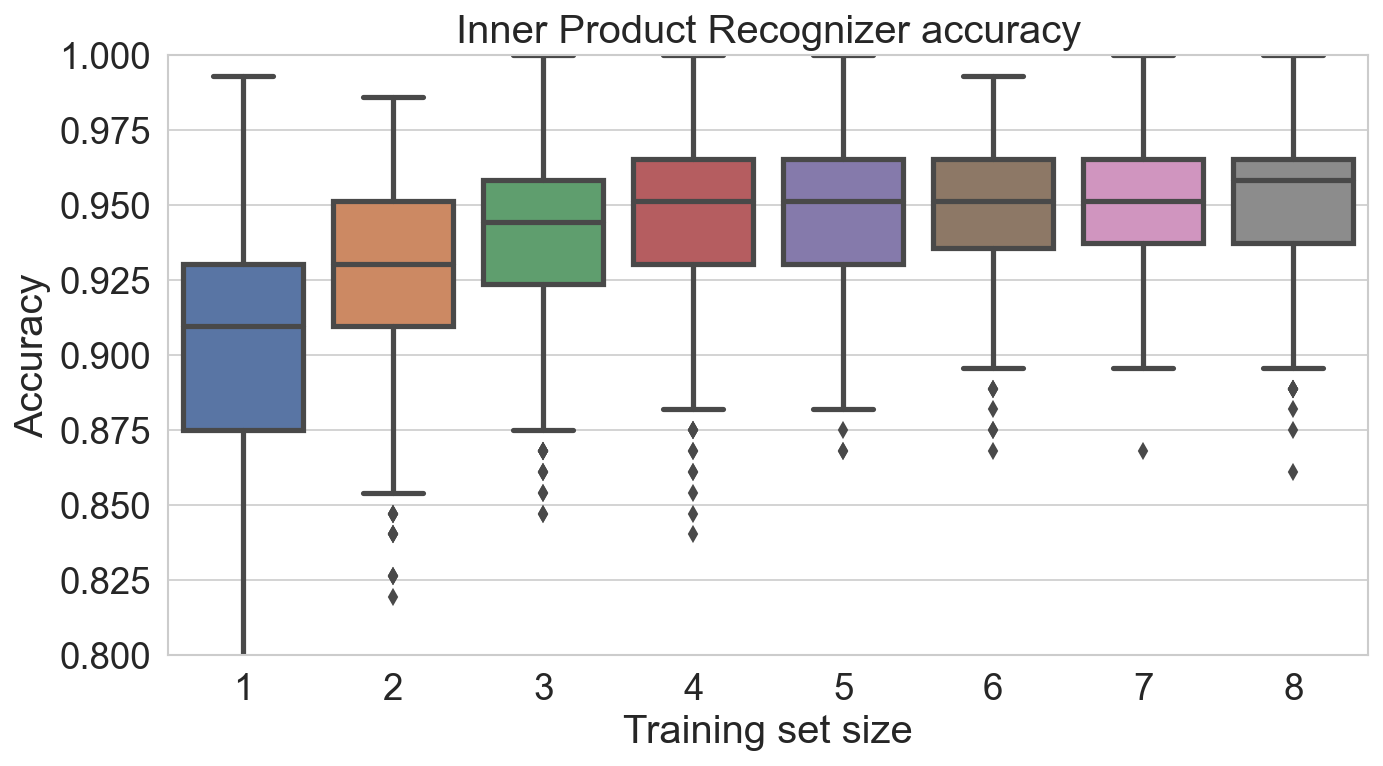

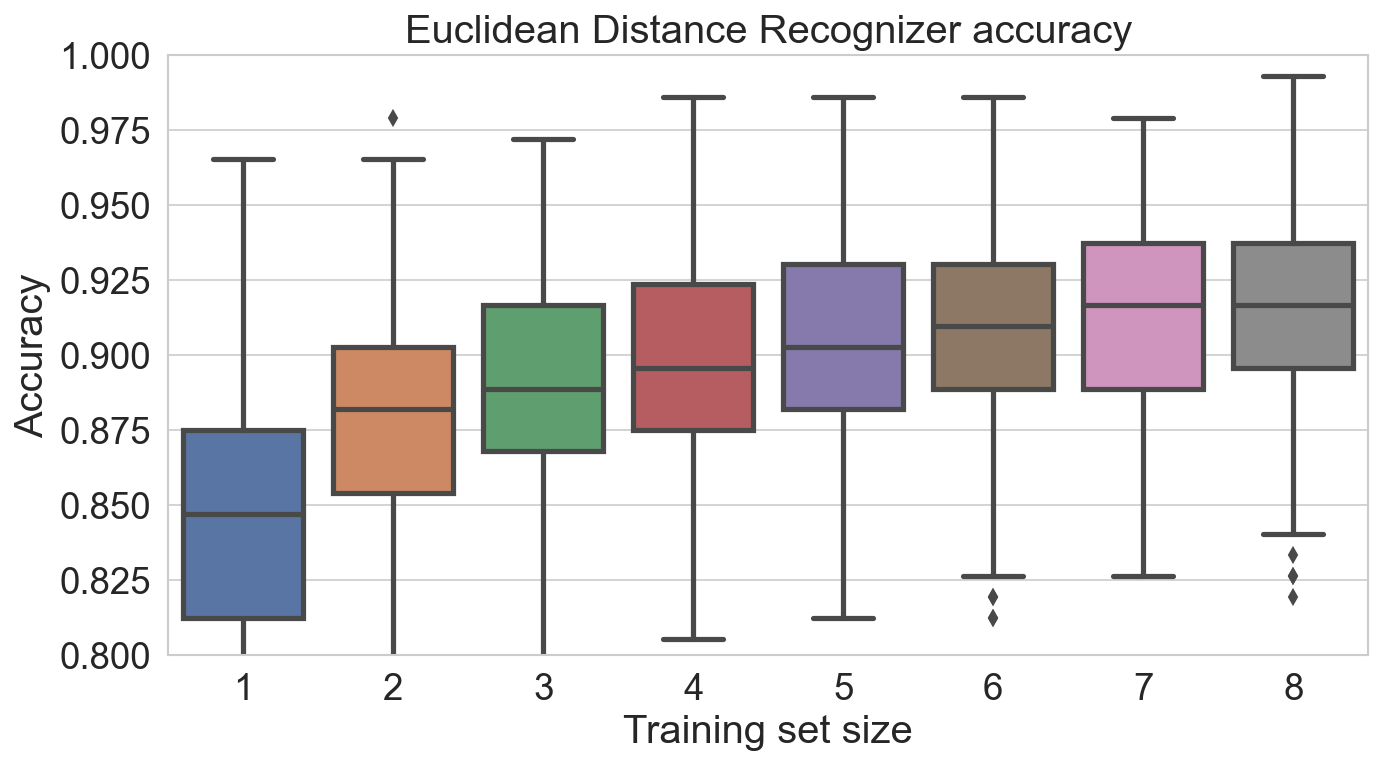

In [75]:
plot_recognizer_accuracy(ip_df, "Inner Product Recognizer")
plot_recognizer_accuracy(ed_df, "Euclidean Distance Recognizer")

In [84]:
def plot_compared_averages(ip_means, ed_means, train_counts):
    fig = plt.figure(figsize=(5, 3), dpi=200)
    axis = fig.add_axes([0, 0, 1, 1])
    axis.set_xlabel("Training set size")
    axis.set_ylabel("Accuracy")
    axis.set_ylim(0.8, 1.0)
    axis.set_title("Comparison of average accuracy")
    sns.lineplot(train_counts, ip_means, label="Inner Product")
    sns.lineplot(train_counts, ed_means, label="Euclidean Distance")
    axis.set_xticks(train_counts)
    plt.legend()

c:\Users\masly\projects\gestures\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\masly\projects\gestures\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


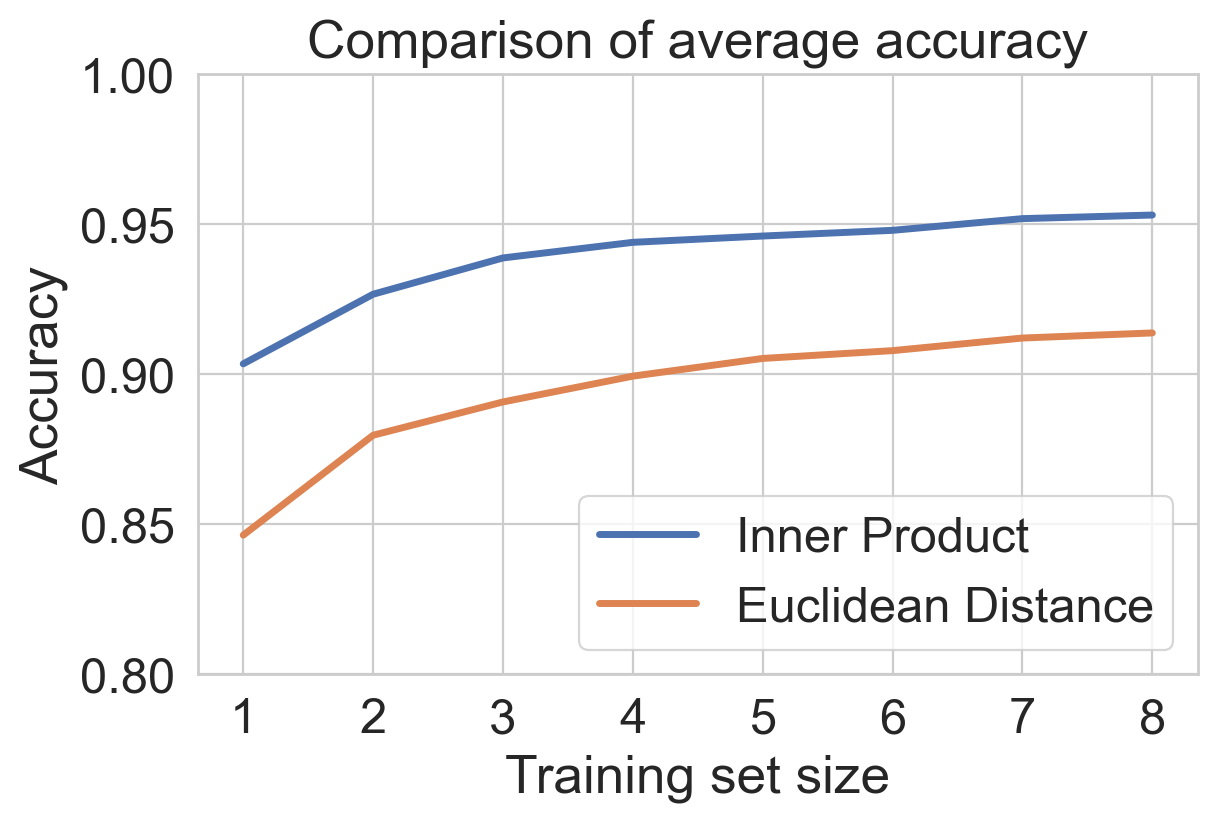

In [85]:
plot_compared_averages(ip_means, ed_means, train_counts)